2021 Statistics and Probability Association Directed Reading Program, with mentorship from Apara. Andrey.

Add a description.

Take another look at how I train the Logit model, getting some strange results

## Import Data

Standard imports for Machine Learning in Jupyter

In [1]:
# Standard imports
import pandas as pd
import numpy as np

Imports specific to the models the notebook uses

In [2]:
# Multinomial Logit Model imports
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

Pagerank Imports

In [3]:
# 
from scipy import sparse

# Understant fast package later
# from fast_pagerank import pagerank
# from fast_pagerank import pagerank_power

Plotting and Visualization imports

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


### Read data files

In [5]:
# Get necessary files

# Paths
filename_CS_edges = 'C:\\Users\\Andre\\OneDrive\\UW\\2021 2 Spring\\SPA DRP\\Network-data\\ComputerScience_edgelist.txt'
filename_CS_vertices = 'C:\\Users\\Andre\\OneDrive\\UW\\2021 2 Spring\\SPA DRP\\Network-data\\ComputerScience_vertexlist.txt'

filename_BUS_edges = 'C:\\Users\\Andre\\OneDrive\\UW\\2021 2 Spring\\SPA DRP\\Network-data\\Business_edgelist.txt'
filename_BUS_vertices = 'C:\\Users\\Andre\\OneDrive\\UW\\2021 2 Spring\\SPA DRP\\Network-data\\Business_vertexlist.txt'

filename_H_edges = 'C:\\Users\\Andre\\OneDrive\\UW\\2021 2 Spring\\SPA DRP\\Network-data\\History_edgelist.txt'
filename_H_vertices = 'C:\\Users\\Andre\\OneDrive\\UW\\2021 2 Spring\\SPA DRP\\Network-data\\History_vertexlist.txt'

# Reading the files
CS_edges = pd.read_csv(filename_CS_edges, sep=None, engine='python') # Good for reading any delimeter
CS_vertices = pd.read_csv(filename_CS_vertices, sep=None, engine='python')
BUS_edges = pd.read_csv(filename_BUS_edges, sep=None, engine='python') # Good for reading any delimeter
BUS_vertices = pd.read_csv(filename_BUS_vertices, sep=None, engine='python')
H_edges = pd.read_csv(filename_H_edges, sep=None, engine='python') # Good for reading any delimeter
H_vertices = pd.read_csv(filename_H_vertices, sep=None, engine='python')


### CS Only
Focusing on CS dataset only for now. Once all issues with model creation are resolved, extend the techniques to all datasets.

Edges columns are:
- 'u' institutions where the doctorate was recieved (choices)
- 'v' institutions which hire faculty (choice makers)

Task: predict which u a v is likely to choose

In [6]:
target = [
    'u' # Use as the target in the edges dataset
]

Investigate the shape of the data

In [7]:
print(CS_edges.count()[0])
print(CS_vertices.count()[0])

4988
206


Because we have roughly 5000 edges, there's no significant difference between packages. For large graphs, use [https://github.com/asajadi/fast-pagerank], but for now use standard page rank packages.

In [8]:
# Rename '# u' to 'u'
CS_edges.rename(columns = {'# u' : 'u'}, inplace = True)
CS_vertices.rename(columns = {'# u' : 'u'}, inplace = True)

In [9]:
CS_edges.head()

,u,v,rank,gender
0,1,1,Asst,M
1,1,1,Assoc,M
2,1,1,Assoc,M
3,1,1,Full,M
4,1,1,Full,M


In [10]:
CS_vertices.head()

,u,pi,USN2010,NRC95,Region,institution
0,1,2.23,1,1,West,Stanford University
1,2,2.31,1,3,West,UC Berkeley
2,3,3.52,1,2,Northeast,MIT
3,4,5.24,11,12,West,California Institute of Technology
4,5,6.12,17,11,Northeast,Harvard University


## Feature Selection

### Multinomial Logit Features

One-hot encode categorical data in vertices.
'_v' signifies for vertices

In [11]:
# One-hot encode categorical data
CS_vertices_onehot = pd.get_dummies(CS_vertices)
features_v = list(CS_vertices_onehot.columns)
features_v

['u',
 'pi',
 'USN2010_.',
 'USN2010_1',
 'USN2010_10',
 'USN2010_11',
 'USN2010_110',
 'USN2010_121',
 'USN2010_127',
 'USN2010_13',
 'USN2010_14',
 'USN2010_17',
 'USN2010_20',
 'USN2010_27',
 'USN2010_28',
 'USN2010_35',
 'USN2010_39',
 'USN2010_44',
 'USN2010_47',
 'USN2010_5',
 'USN2010_53',
 'USN2010_58',
 'USN2010_61',
 'USN2010_63',
 'USN2010_7',
 'USN2010_72',
 'USN2010_79',
 'USN2010_8',
 'USN2010_91',
 'USN2010_99',
 'NRC95_.',
 'NRC95_1',
 'NRC95_10',
 'NRC95_11',
 'NRC95_12',
 'NRC95_13',
 'NRC95_14',
 'NRC95_15',
 'NRC95_16',
 'NRC95_17',
 'NRC95_18',
 'NRC95_19',
 'NRC95_2',
 'NRC95_20',
 'NRC95_21',
 'NRC95_22',
 'NRC95_23',
 'NRC95_24',
 'NRC95_25',
 'NRC95_26',
 'NRC95_27',
 'NRC95_28',
 'NRC95_29',
 'NRC95_3',
 'NRC95_30',
 'NRC95_31',
 'NRC95_32',
 'NRC95_33',
 'NRC95_34',
 'NRC95_35',
 'NRC95_36',
 'NRC95_37',
 'NRC95_38',
 'NRC95_39',
 'NRC95_4',
 'NRC95_40',
 'NRC95_42',
 'NRC95_43',
 'NRC95_44',
 'NRC95_45',
 'NRC95_46',
 'NRC95_47',
 'NRC95_48',
 'NRC95_49',
 '

One-hot encode categorical data in edges.
'_e' signifies for edges

In [12]:
# One-hot encode categorical data
CS_edges_onehot = pd.get_dummies(CS_edges)
features_e = list(CS_edges_onehot.columns)
features_e.remove('u') 
target_e = ['u'] # We are trying to predict this
features_e

['v', 'rank_Assoc', 'rank_Asst', 'rank_Full', 'gender_F', 'gender_M']

In [13]:
(CS_edges_onehot)

,u,v,rank_Assoc,rank_Asst,rank_Full,gender_F,gender_M
0,1,1,0,1,0,0,1
1,1,1,1,0,0,0,1
2,1,1,1,0,0,0,1
3,1,1,0,0,1,0,1
4,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...
4983,206,201,0,0,1,0,1
4984,206,203,0,1,0,0,1
4985,206,205,0,1,0,0,1
4986,206,205,1,0,0,1,0


## Join datasets

In [14]:
CS_merged = CS_edges.merge(CS_vertices, 'left', 'u')

In [15]:
CS_merged.columns

Index(['u', 'v', 'rank', 'gender', 'pi', 'USN2010', 'NRC95', 'Region  ',
       'institution'],
      dtype='object')

In [16]:
# Pandas rename to remove spaces in column names
CS_merged.rename(columns={"Region  ":"Region"}, inplace=True) # inplace saves me a variable
CS_merged.columns

Index(['u', 'v', 'rank', 'gender', 'pi', 'USN2010', 'NRC95', 'Region',
       'institution'],
      dtype='object')

In [17]:
# One-hot encode 'region'
CS_merged_onehot = pd.get_dummies(CS_merged, columns = ["Region"])
# features_e = list(CS_edges_onehot.columns)

features_e = [
#     CS_merged_onehot.columns, # One hot encoded region
    'Region_Canada   ', 
    'Region_Earth    ', 
    'Region_Midwest  ',
    'Region_Northeast', 
    'Region_South    ', 
    'Region_West     ',
    'USN2010',
    'NRC95'
]
 
target_e = ['u'] # We are trying to predict which u is chosen
features_e

['Region_Canada   ',
 'Region_Earth    ',
 'Region_Midwest  ',
 'Region_Northeast',
 'Region_South    ',
 'Region_West     ',
 'USN2010',
 'NRC95']

### Replace . with -1 in USN2010

In [18]:
# US national ranks do not exist for international rankings
# Convert them to 5000, something very low, while keeping the existing rankings the same
# CS_merged_onehot['USN2010'] = CS_merged_onehot['USN2010'].map({'.':5000})
# CS_merged_onehot['NRC95'] = CS_merged_onehot['NRC95'].map({'.':5000})

CS_merged_onehot.USN2010[CS_merged_onehot.USN2010 == '.'] = -1
CS_merged_onehot.NRC95[CS_merged_onehot.NRC95 == '.'] = -1


<ipython-input-18-5f8ce2c38d26>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CS_merged_onehot.USN2010[CS_merged_onehot.USN2010 == '.'] = -1
<ipython-input-18-5f8ce2c38d26>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CS_merged_onehot.NRC95[CS_merged_onehot.NRC95 == '.'] = -1


### Split datasets

In [19]:
# Split the data into train, validation, test
from sklearn.model_selection import train_test_split

# Only train and validation for now
train_CS_e, validation_CS_e = train_test_split(CS_merged_onehot, test_size=0.25, random_state=1)


Should correct this from "_e" to "all", as it used vertices and edges as features

In [20]:
train_CS_e

,u,v,rank,gender,pi,USN2010,NRC95,institution,Region_Canada,Region_Earth,Region_Midwest,Region_Northeast,Region_South,Region_West
4910,206,162,Assoc,M,206.00,-1,-1,All others,0,1,0,0,0,0
4598,206,65,Assoc,F,206.00,-1,-1,All others,0,1,0,0,0,0
2644,34,50,Assoc,M,38.11,28,32,University of Virginia,0,0,0,0,1,0
784,5,97,Full,M,6.12,17,11,Harvard University,0,0,0,1,0,0
4381,193,193,Full,M,178.55,127,92,Nova Southeastern University,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,37,152,Full,F,39.69,10,29,Georgia Tech,0,0,0,0,1,0
2763,35,191,Assoc,M,38.27,20,23,Purdue University,0,0,1,0,0,0
905,6,147,Assoc,M,8.29,5,5,Cornell University,0,0,0,1,0,0
3980,97,197,Full,M,102.17,99,68,Louisiana State University,0,0,0,0,1,0


In [21]:
train_CS_e[target_e].head()

,u
4910,206
4598,206
2644,34
784,5
4381,193


In [22]:
#MNLogit
np.unique(CS_merged["Region"])

array(['Canada   ', 'Earth    ', 'Midwest  ', 'Northeast', 'South    ',
       'West     '], dtype=object)

In [23]:
# Convert to float
train_CS_e[features_e]

,Region_Canada,Region_Earth,Region_Midwest,Region_Northeast,Region_South,Region_West,USN2010,NRC95
4910,0,1,0,0,0,0,-1,-1
4598,0,1,0,0,0,0,-1,-1
2644,0,0,0,0,1,0,28,32
784,0,0,0,1,0,0,17,11
4381,0,0,0,0,1,0,127,92
...,...,...,...,...,...,...,...,...
2895,0,0,0,0,1,0,10,29
2763,0,0,1,0,0,0,20,23
905,0,0,0,1,0,0,5,5
3980,0,0,0,0,1,0,99,68


# Multinomial Logit with sklearn

We want a Multinomial Logit Model, because we have multiple (more than two) discrete outcomes.

To do:
- Consider using standard scalar from sklearn to standardize features
- Resolve train_CS_e[target_e] as a 1d array, not a column vector warning

### Prepare the Features to be Used

In [24]:
# Check that train_CS_e[target_e] is a 1d array, not a column vector
train_CS_e[target_e]

,u
4910,206
4598,206
2644,34
784,5
4381,193
...,...
2895,37
2763,35
905,6
3980,97


### Determine Optimal Multinomial Logit Parameters
Using Grid Search

Reshape input to resolve the DataConversionWarning?

In [25]:
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25,100,1000]}
# task 2: create a logistic regression model
clf = LogisticRegression(multi_class = 'multinomial')
# task 3: initialize grid search on the logistic regression model
grid_clf = GridSearchCV(clf, param_grid=grid_values)
# task 4: fit your training data using grid search
grid_clf.fit(train_CS_e[features_e], train_CS_e[target_e])

C:\Users\Andre\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or '

C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Andre\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Andre\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Andre\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Andre\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Andre\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

GridSearchCV(estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25, 100,
                               1000],
                         'penalty': ['l1', 'l2']})

In [26]:
# Predict using the parameters found with grid search
y_pred = grid_clf.predict(validation_CS_e[features_e])

In [27]:
# How good were the grid search predictions?
score = grid_clf.score(validation_CS_e[features_e], validation_CS_e[target_e])
print(score)

0.7032878909382518


Instead of making the unknown rank 5000, making it -1 increased the accuracy from 14% to 70%. Normalize the features in the final version!

In [28]:
grid_clf.best_params_

{'C': 25, 'penalty': 'l2'}

In [29]:
grid_clf.best_estimator_

LogisticRegression(C=25, multi_class='multinomial')

### Train the Optimal Multinomial Logit Model

In [30]:
multinom_logit_model_optimal = LogisticRegression(penalty='l2', random_state=1, multi_class = 'multinomial', C=0.09)
multinom_logit_model_optimal.fit(train_CS_e[features_e], train_CS_e[target_e])

C:\Users\Andre\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.09, multi_class='multinomial', random_state=1)

In [31]:
train_CS_e[features_e]

,Region_Canada,Region_Earth,Region_Midwest,Region_Northeast,Region_South,Region_West,USN2010,NRC95
4910,0,1,0,0,0,0,-1,-1
4598,0,1,0,0,0,0,-1,-1
2644,0,0,0,0,1,0,28,32
784,0,0,0,1,0,0,17,11
4381,0,0,0,0,1,0,127,92
...,...,...,...,...,...,...,...,...
2895,0,0,0,0,1,0,10,29
2763,0,0,1,0,0,0,20,23
905,0,0,0,1,0,0,5,5
3980,0,0,0,0,1,0,99,68


In [32]:
train_CS_e[target_e]

,u
4910,206
4598,206
2644,34
784,5
4381,193
...,...
2895,37
2763,35
905,6
3980,97


In [33]:
np.unique(train_CS_e[target_e])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118,
       119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133,
       134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 150, 151, 152, 153, 154, 155, 156, 160, 162, 163, 164, 166,
       167, 168, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 183,
       187, 188, 189, 190, 191, 192, 193, 194, 198, 204, 206], d

In [34]:
len(np.unique(train_CS_e[target_e])) # Expected: some universities are not represented, but not many

# Take feature for each of the 180 chosen, multiply these by their corresponding coefficients
# Fancy matrix multiplication

180

In [35]:
# Want parameters of logistic model; use model.coef_
multinom_logit_model_optimal.coef_

array([[-2.84302500e-03, -3.08717755e-02, -2.96072567e-02, ...,
         2.94018356e+00,  2.81420394e-01, -2.74573657e-01],
       [-2.16290489e-02, -2.73003011e-02, -7.91318078e-02, ...,
         2.74237528e+00, -1.20821032e+00,  7.91242808e-01],
       [-5.19887953e-03, -2.93215155e-02, -8.84293167e-02, ...,
        -1.81558063e-01, -1.23966287e+00, -3.46288157e-01],
       ...,
       [-2.74367063e-03, -2.82745224e-02, -2.37441160e-02, ...,
        -4.12710564e-02,  6.49880972e-01, -3.39546914e-01],
       [-2.74367063e-03, -2.82745224e-02, -2.37441160e-02, ...,
        -4.12710564e-02,  6.49880972e-01, -3.39546914e-01],
       [-2.20608833e-03,  4.58202326e+00, -8.08644664e-03, ...,
        -1.54920141e-02, -5.28268243e+00, -5.51541997e+00]])

In [36]:
coefficients = multinom_logit_model_optimal.coef_ #[0] 

print('Smallest coefficient', coefficients.min())
print('Largest coefficient:', coefficients.max())

Smallest coefficient -5.515419966155382
Largest coefficient: 4.582023259947321


# TODO: Interpret Coefficients

In [37]:
coefficients # Take this vector, multiply it by each feature, will result in ranking!

array([[-2.84302500e-03, -3.08717755e-02, -2.96072567e-02, ...,
         2.94018356e+00,  2.81420394e-01, -2.74573657e-01],
       [-2.16290489e-02, -2.73003011e-02, -7.91318078e-02, ...,
         2.74237528e+00, -1.20821032e+00,  7.91242808e-01],
       [-5.19887953e-03, -2.93215155e-02, -8.84293167e-02, ...,
        -1.81558063e-01, -1.23966287e+00, -3.46288157e-01],
       ...,
       [-2.74367063e-03, -2.82745224e-02, -2.37441160e-02, ...,
        -4.12710564e-02,  6.49880972e-01, -3.39546914e-01],
       [-2.74367063e-03, -2.82745224e-02, -2.37441160e-02, ...,
        -4.12710564e-02,  6.49880972e-01, -3.39546914e-01],
       [-2.20608833e-03,  4.58202326e+00, -8.08644664e-03, ...,
        -1.54920141e-02, -5.28268243e+00, -5.51541997e+00]])

In [38]:
len(coefficients)

180

In [39]:
len(multinom_logit_model_optimal.coef_)

180

### Calculate Ranking
Multiply the coefficients vectors by each feature, which will result in rankings!

Take feature for each of the 180 chosen, multiply these by their corresponding coefficients (Fancy matrix multiplication)

In [40]:
# We need to get the rows corresponding to each of the 180 unique targets chosen
# Does numpy.unique select the first value of many identical ones? If so, write code to filter out the first instance of each

# Even better, np.unique has parameters to return the indices!
# Which do I want (https://numpy.org/doc/stable/reference/generated/numpy.unique.html)? Probably return_index
np.unique(train_CS_e[target_e], return_index = True) # Seems it returns an array of ranks and an array of indices!

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118,
        119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133,
        134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 150, 151, 152, 153, 154, 155, 156, 160, 162, 163, 164, 166,
        167, 168, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 183,
        187, 188, 189, 190, 191, 192, 193, 194, 198

In [41]:
univ, univ_indexes = np.unique(train_CS_e[target_e], return_index = True)

In [42]:
unique_features = train_CS_e[features_e].iloc[univ_indexes]

In [43]:
unique_features

,Region_Canada,Region_Earth,Region_Midwest,Region_Northeast,Region_South,Region_West,USN2010,NRC95
93,0,0,0,0,0,1,1,1
292,0,0,0,0,0,1,1,3
524,0,0,0,1,0,0,1,2
714,0,0,0,0,0,1,11,12
784,0,0,0,1,0,0,17,11
...,...,...,...,...,...,...,...,...
4381,0,0,0,0,1,0,127,92
4383,0,0,0,0,1,0,127,92
4384,0,0,0,0,1,0,127,92
4386,0,0,0,0,1,0,127,92


### Logit Rank Plan
1. Use grid search to find best parameters for multinomial logit.
2. Train multinomial logit with these parameters.
3. Get the indices of the unique universities predicted by the model.
4. Take the dot product of the coefficients for a row with the respective features for that row. Repeat for all rows.

In [44]:
# Transpose one of the matrices (arbitrarily choosing to transpose coefficients)
coefficients_T = coefficients.transpose()

In [45]:
coefficients_T.shape

(8, 180)

In [46]:
# For the ith row in unique_features and the ith column in coefficients_T, take their dot product (multiply the vectors)
# Store the result to a new dataframe/array that is 180x1

# ndarray

ranks_logit = np.ndarray([180])

for i in range(0, 180, 1): 
    features_vector = (unique_features.iloc[i:i+1,:]).to_numpy()
    coef_vector = (coefficients_T[:,i:i+1])#.to_numpy
    
    features_vector = features_vector[0,:] # Reduce the dimension, knowing that it was a 2D array with only one row
    coef_vector = coef_vector[:,0] # Reduce the dimension, knowing that it was a 2D array with only one column
    
#     print(features_vector)
#     print(coef_vector)
    
    dot_product = 0
    for j in range(0, len(features_vector)):
        dot_product += float(features_vector[j]) * coef_vector[j]
#         print(dot_product)
    
#     print("Final product: ")
#     print(dot_product)
#     print()
#     print(features_vector.dtype)
    
    ranks_logit[i] = dot_product # REMEMBER, when looking for universities, this is ONE LESS than index for university
    
#     a = np.matmul(unique_features.iloc[i:i+1,:], coefficients_T[:,i:i+1]) # Row i, column i
#     a = np.matmul(float(features_vector), float(coef_vector))

    # The error I keep seeing is that coef_vector has float values, features_vector has integer values
    # The error is: TypeError: can't multiply sequence by non-int of type 'float'

#     print(features_vector)
#     print(coef_vector)
#     print(a)

In [47]:
ranks_logit # Each university's utility value as determined by the multinomial logit model

array([ 2.9470303 ,  3.90789338,  1.87449933,  4.78442732,  9.5478197 ,
        3.25754271,  4.5067715 ,  4.4379253 , 10.07226346,  4.19004973,
        5.03099989,  5.39323982,  9.36249524,  8.45217033,  6.20441222,
       17.8103135 , 19.71951725,  4.34974455, 10.93962033,  8.31492458,
       84.88075407, 30.0397785 ,  8.3939817 , 12.70669396,  9.0613777 ,
        9.31047025,  6.60678013,  9.36107077, 10.53319813, 10.68891593,
       24.65335193, 11.85748172, 18.35539965, 12.24724655,  9.44712244,
       17.7046974 , 19.09684853, 11.64726627, 25.77783044, 24.9259489 ,
       14.82882782, 14.25421993, 18.43480637, 24.54151646, 18.86099636,
       83.75649932, 24.2788974 , 34.95730595, 17.10335458, 15.80629252,
       20.54767777, 21.74427527, 63.53533614, 24.36925216, 84.4406417 ,
       15.22564961, 83.67131689, 33.26345008, 25.15877033, 43.405337  ,
       31.63229852, 30.36418031, 34.73849296, 40.90614067, 83.16674608,
       82.99289055, 24.43002207, 39.55482243, 21.05865954, 18.57

In [48]:
# ranks_logit = unique_features * coefficients # TypeError: can't multiply sequence by non-int of type 'float'

# HELP HERE, How does this obtain ranks? Read paper again

In [49]:
# I want to multiply the (108,8) features by the (108,8) coefficients array, resulting in (ranks?)

# Page Rank

### Prepare Data for Creating an Adjacency Matrix

In [50]:
# Set the filter for the edge list
universities = [
    'u',
    'v'
]
# Filter the edge list
CS_edges_simple = CS_edges[universities]

In [51]:
print(CS_edges_simple)

        u    v
0       1    1
1       1    1
2       1    1
3       1    1
4       1    1
...   ...  ...
4983  206  201
4984  206  203
4985  206  205
4986  206  205
4987  206  205

[4988 rows x 2 columns]


## The Plan
1. Create dataframe of zeroes. 
2. Populate an entry each row of edge list. 
3. Add ones matrix. 
4. Scale each column. 
5. Obtain eigenvalues, determine ranks.

### 1. Initialize Matrix as Zeroes

In [52]:
# Create all zero dataframe
all_zeroes = np.zeros(shape=(207,206))
CS_pagerank_matrix = pd.DataFrame(all_zeroes, columns=np.arange(1,207,1))
CS_pagerank_matrix.drop([0], inplace = True) # Needed to get indices to match u, v values

CS_pagerank_matrix

,1,2,3,4,5,6,7,8,9,10,...,197,198,199,200,201,202,203,204,205,206
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Update Matrix with Edge List values

#### Note: u by v matrix (rows are u's, columns are v's)

In [53]:
# Populate all zero dataframe: for each row in edge list, add 1 to the corresponding edge
for row_index in range(0, len(CS_edges_simple)):
    u = CS_edges_simple.at[row_index, 'u'] # u coord is column
    v = CS_edges_simple.at[row_index, 'v'] # v coord is row
#     print(row_index)
#     print(CS_edges_simple.at[row_index, 'v'])
    CS_pagerank_matrix.at[u, v] += 1

CS_pagerank_matrix

,1,2,3,4,5,6,7,8,9,10,...,197,198,199,200,201,202,203,204,205,206
1,9.0,9.0,14.0,0.0,2.0,7.0,11.0,7.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.0,7.0,12.0,2.0,3.0,5.0,15.0,3.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.0,8.0,27.0,4.0,2.0,8.0,17.0,3.0,5.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,1.0,2.0,2.0,0.0,3.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,2.0,3.0,0.0,2.0,2.0,4.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Make a copy of the directed adjacency matrix to use in SpringRank
CS_dir_adj_matrix = CS_pagerank_matrix.copy()

### 3. Add Teleportation possibility (random university hire)

Add one to every element to simulate the chance to teleport to any page from any page 
(adds a link from a page to all pages)
Makes sense in context: v=206 has no hires represented, so if they get new faculty, equal chance from any university

#### DO NOT run more than once! [1,1] should be 10.0

In [55]:
CS_pagerank_matrix += 1
CS_pagerank_matrix 

,1,2,3,4,5,6,7,8,9,10,...,197,198,199,200,201,202,203,204,205,206
1,10.0,10.0,15.0,1.0,3.0,8.0,12.0,8.0,3.0,6.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,9.0,8.0,13.0,3.0,4.0,6.0,16.0,4.0,2.0,8.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,9.0,9.0,28.0,5.0,3.0,9.0,18.0,4.0,6.0,8.0,...,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4.0,2.0,3.0,3.0,1.0,4.0,3.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,3.0,3.0,4.0,1.0,3.0,3.0,5.0,2.0,3.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
203,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
204,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0
205,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [56]:
# Make a copy of the directed adjacency matrix (with teleportation) to use in SpringRank
CS_dir_adj_matrix_tp = CS_pagerank_matrix.copy()

### 4. Normalize Columns to Sum to One

In [57]:
for col in CS_pagerank_matrix.columns: # for each column
#     print(col)
    s = sum(CS_pagerank_matrix[col])# sum of the column
#     print(s)
    CS_pagerank_matrix[col] = CS_pagerank_matrix[col] / s
    # Create a new column (in place?) of the old column divided by the sum
CS_pagerank_matrix

,1,2,3,4,5,6,7,8,9,10,...,197,198,199,200,201,202,203,204,205,206
1,0.038760,0.039526,0.053763,0.004505,0.013216,0.030651,0.036474,0.033898,0.013274,0.023715,...,0.004545,0.004484,0.004630,0.004386,0.004484,0.004717,0.004566,0.004484,0.004405,0.004854
2,0.034884,0.031621,0.046595,0.013514,0.017621,0.022989,0.048632,0.016949,0.008850,0.031621,...,0.004545,0.004484,0.004630,0.004386,0.004484,0.004717,0.004566,0.004484,0.004405,0.004854
3,0.034884,0.035573,0.100358,0.022523,0.013216,0.034483,0.054711,0.016949,0.026549,0.031621,...,0.004545,0.004484,0.009259,0.004386,0.004484,0.004717,0.004566,0.004484,0.004405,0.004854
4,0.015504,0.007905,0.010753,0.013514,0.004405,0.015326,0.009119,0.004237,0.004425,0.007905,...,0.004545,0.004484,0.004630,0.004386,0.004484,0.004717,0.004566,0.004484,0.004405,0.004854
5,0.011628,0.011858,0.014337,0.004505,0.013216,0.011494,0.015198,0.008475,0.013274,0.003953,...,0.004545,0.004484,0.004630,0.004386,0.004484,0.004717,0.004566,0.004484,0.004405,0.004854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.003876,0.003953,0.003584,0.004505,0.004405,0.003831,0.003040,0.004237,0.004425,0.003953,...,0.004545,0.004484,0.004630,0.004386,0.004484,0.004717,0.004566,0.004484,0.004405,0.004854
203,0.003876,0.003953,0.003584,0.004505,0.004405,0.003831,0.003040,0.004237,0.004425,0.003953,...,0.004545,0.004484,0.004630,0.004386,0.004484,0.004717,0.004566,0.004484,0.004405,0.004854
204,0.003876,0.003953,0.003584,0.004505,0.004405,0.003831,0.003040,0.004237,0.004425,0.003953,...,0.004545,0.004484,0.004630,0.004386,0.004484,0.004717,0.004566,0.013453,0.004405,0.004854
205,0.003876,0.003953,0.003584,0.004505,0.004405,0.003831,0.003040,0.004237,0.004425,0.003953,...,0.004545,0.004484,0.004630,0.004386,0.004484,0.004717,0.004566,0.004484,0.004405,0.004854


### 5. Find eigenvalues, eigenvectors

In [58]:
eVals, eVecs = np.linalg.eig(CS_pagerank_matrix)

In [59]:
eVals

array([ 1.00000000e+00+0.00000000e+00j,  1.43026359e-01+0.00000000e+00j,
        6.69822632e-02+1.11951399e-02j,  6.69822632e-02-1.11951399e-02j,
        5.29892561e-02+0.00000000e+00j,  4.35379363e-02+0.00000000e+00j,
        4.00829043e-02+0.00000000e+00j,  3.40110991e-02+1.70064545e-02j,
        3.40110991e-02-1.70064545e-02j,  3.41331933e-02+3.38925929e-04j,
        3.41331933e-02-3.38925929e-04j,  2.80462915e-02+2.63845003e-03j,
        2.80462915e-02-2.63845003e-03j, -1.71279089e-02+0.00000000e+00j,
        2.06328079e-02+1.11011119e-02j,  2.06328079e-02-1.11011119e-02j,
        1.22711300e-02+1.51982762e-02j,  1.22711300e-02-1.51982762e-02j,
        2.50223995e-02+0.00000000e+00j,  2.26150728e-02+6.18899582e-03j,
        2.26150728e-02-6.18899582e-03j, -1.22241178e-02+7.57489097e-03j,
       -1.22241178e-02-7.57489097e-03j,  2.26827045e-02+0.00000000e+00j,
       -1.27020440e-02+3.25712609e-03j, -1.27020440e-02-3.25712609e-03j,
       -1.12664297e-02+5.64827830e-03j, -1.12664297

In [60]:
eVecs

array([[ 1.26700376e-01+0.j        , -4.79111719e-01+0.j        ,
        -4.07818339e-01-0.00871052j, ...,  9.45579194e-04+0.j        ,
        -3.60401493e-02+0.j        , -9.86759842e-02+0.j        ],
       [ 1.29905779e-01+0.j        , -4.30394354e-01+0.j        ,
        -2.88688816e-01-0.05632255j, ..., -1.23290129e-01+0.j        ,
         4.45895076e-02+0.j        ,  1.19964638e-01+0.j        ],
       [ 1.62455248e-01+0.j        , -6.88149852e-01+0.j        ,
        -5.53750816e-01+0.j        , ..., -9.48017434e-02+0.j        ,
         1.15946365e-01+0.j        ,  9.84941938e-02+0.j        ],
       ...,
       [ 6.09126078e-02+0.j        ,  8.61166572e-03+0.j        ,
        -2.01053175e-03-0.00066756j, ...,  2.35375947e-16+0.j        ,
        -3.41085073e-16+0.j        , -4.22160571e-16+0.j        ],
       [ 6.03663064e-02+0.j        ,  8.07166267e-03+0.j        ,
        -1.73411342e-03-0.00062438j, ...,  1.46245306e-03+0.j        ,
        -8.50904070e-04+0.j        

The first printed array is eVals, which constitutes the eigenvalues. The second printed matrix below it is eVecs, whose columns are the eigenvectors corresponding to the eigenvalues in eVals. Meaning, to the eVals[i] eigenvalue, the corresponding eigenvector is the eVecs[:,i] column in matrix eVecs. 

### 6. Interpret PageRank
The larger an eigenvalue, the more important that choice is. Let's plot the eigenvalues of universities and their USN rank, and observe any patterns.
Helpfully, the eigenvalues are outputted such that they line up with the university order (1-206).

In [61]:
ranks_pr = eVals
# Ranks from PageRank

# SpringRank

### Larremore Lab SpringRank
Install SpringRank version 0.0.7

In [62]:
%pip install SpringRank

Note: you may need to restart the kernel to use updated packages.


In [63]:
import SpringRank as sr

In [64]:
type(CS_dir_adj_matrix) # Need this to be numpy array

pandas.core.frame.DataFrame

In [65]:
CS_dir_adj_matrix_numpy = CS_dir_adj_matrix.to_numpy()
CS_dir_adj_matrix_numpy

array([[ 9.,  9., 14., ...,  0.,  0.,  0.],
       [ 8.,  7., 12., ...,  0.,  0.,  0.],
       [ 8.,  8., 27., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 5.,  4.,  6., ...,  0.,  3.,  0.]])

Must be numpy array to work!

In [66]:
type(CS_dir_adj_matrix_numpy) # Need this to be numpy array

numpy.ndarray

In [67]:
ranks_sr = sr.get_ranks(CS_dir_adj_matrix_numpy)
ranks_sr

array([ 1.37761380e-04,  1.55674956e-02, -1.82837809e-02, -1.60184063e-01,
       -1.68615514e-01, -3.74286714e-01, -4.49361368e-01, -3.00125510e-01,
       -3.79989216e-01, -4.50548733e-01, -4.76956802e-01, -4.49744767e-01,
       -4.58617837e-01, -4.62360282e-01, -5.11609964e-01, -6.67625912e-01,
       -6.65912698e-01, -5.42453327e-01, -5.77181851e-01, -6.32719318e-01,
       -4.88303423e-01, -6.70678622e-01, -6.66358077e-01, -7.40901805e-01,
       -6.43404493e-01, -7.56812770e-01, -6.60604847e-01, -6.92923402e-01,
       -7.58695826e-01, -8.18574483e-01, -7.13755297e-01, -8.66882984e-01,
       -9.21695119e-01, -7.88587978e-01, -7.63738632e-01, -7.75621186e-01,
       -9.06194247e-01, -8.84729475e-01, -8.25607516e-01, -8.77573879e-01,
       -7.50057677e-01, -9.47374517e-01, -1.00477169e+00, -7.54424763e-01,
       -9.62025508e-01, -8.70826576e-01, -1.16080459e+00, -8.64823555e-01,
       -1.07938871e+00, -9.97947225e-01, -1.11072206e+00, -1.08063385e+00,
       -1.33069124e+00, -

### n. Interpret SpringRanks

In [68]:
len(ranks_sr)

206

# Visualizations
In this section we compare the different ranking methods. 
First, evaluate how consistent they are.

### IDs of Universities of Interest
1: Stanford (Dark green, pine tree)

3: MIT (Crimson)

10: University of Washington (Purple)

173: Wright State University (Blue, dodgerblue)

(in terms of indices, these are -1)


In [69]:
# Interested in entries for these universities in particular

# Logit: have IDs, find these among the unique 

# PageRank: eVals 1, 3, 10, 174 (outputted in order)

# SpringRank: 

In [70]:
# How is each rank ordered?

# SpringRank ranks
ranks_sr

# PageRank ranks
ranks_pr

#  Take norm

array([ 1.00000000e+00+0.00000000e+00j,  1.43026359e-01+0.00000000e+00j,
        6.69822632e-02+1.11951399e-02j,  6.69822632e-02-1.11951399e-02j,
        5.29892561e-02+0.00000000e+00j,  4.35379363e-02+0.00000000e+00j,
        4.00829043e-02+0.00000000e+00j,  3.40110991e-02+1.70064545e-02j,
        3.40110991e-02-1.70064545e-02j,  3.41331933e-02+3.38925929e-04j,
        3.41331933e-02-3.38925929e-04j,  2.80462915e-02+2.63845003e-03j,
        2.80462915e-02-2.63845003e-03j, -1.71279089e-02+0.00000000e+00j,
        2.06328079e-02+1.11011119e-02j,  2.06328079e-02-1.11011119e-02j,
        1.22711300e-02+1.51982762e-02j,  1.22711300e-02-1.51982762e-02j,
        2.50223995e-02+0.00000000e+00j,  2.26150728e-02+6.18899582e-03j,
        2.26150728e-02-6.18899582e-03j, -1.22241178e-02+7.57489097e-03j,
       -1.22241178e-02-7.57489097e-03j,  2.26827045e-02+0.00000000e+00j,
       -1.27020440e-02+3.25712609e-03j, -1.27020440e-02-3.25712609e-03j,
       -1.12664297e-02+5.64827830e-03j, -1.12664297

Pagerank, Springrank, larger = higher rated

USN2010 lower = higher rank

C:\Users\Andre\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


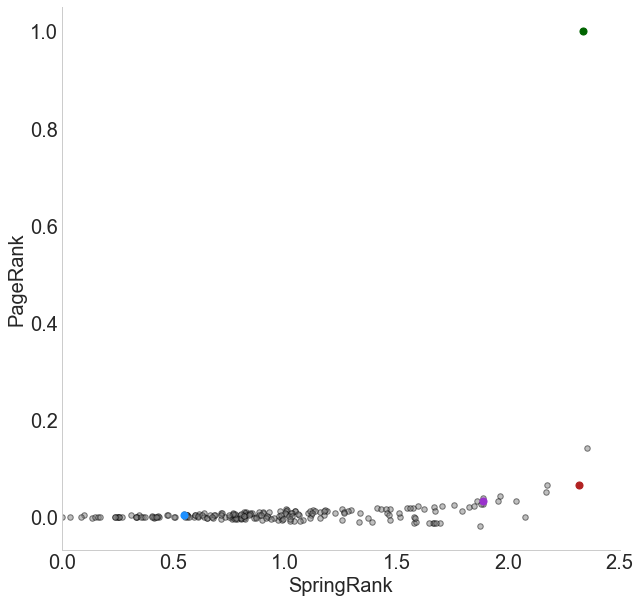

In [71]:
# WORKING COPY
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.rcParams["axes.spines.right"] = False # Get rid of top and right axes/borders
plt.rcParams["axes.spines.top"] = False # Get rid of top and right axes/borders
plt.rcParams.update({'font.size': 20}) # Change font size

plt.scatter(ranks_sr - np.min(ranks_sr), ranks_pr, s = 30, color = 'gray', alpha=0.5, edgecolor = 'black') # Markers are smaller & transparent

# CAN LOOP THIS FOR EACH INTERESTING UNIVERSITY
# Look at matplotlib colors

plt.scatter(ranks_sr[1-1] - np.min(ranks_sr), ranks_pr[1-1], s = 50, color = 'darkgreen')
plt.scatter(ranks_sr[3-1] - np.min(ranks_sr), ranks_pr[3-1], s = 50, color = 'firebrick')
plt.scatter(ranks_sr[10-1] - np.min(ranks_sr), ranks_pr[10-1], s = 50, color = 'darkorchid')
plt.scatter(ranks_sr[173-1] - np.min(ranks_sr), ranks_pr[173-1], s = 50, color = 'dodgerblue')
# marker = 'o',
# Edges help us see point clusters (edge color distict from main color)
# Specific colors to highlight universities: dodgerblue
# Shifted negatives to positives for spring rank ranks
plt.xlabel("SpringRank") # No need to tell them these are ranks
plt.ylabel("PageRank")
plt.xlim([0,2.5])

# plt.title("PageRank and SpringRank Comparison")
# This title is redundant to the axes

plt.grid(False) # Remove grid
# axes.xaxis.set_visible(False) # Remove axis marks
# plt.xticks # Ticks are fine

# Power move: get rid of ticks from 0.4 to 0.8
# Z-order argument to move point on top of the axis so it is not occluded

# Anything that does not add value can be removed without loss of information

# The three plots will be each ranking model compared to USN ranking
# Two more plots comparing springrank to each of discrete logit and pagerank
    # Add another slide, SpringRank gets best of both worlds; that is where the last two plots appear

plt.show()

In [72]:
CS_vertices['USN2010']

0        1
1        1
2        1
3       11
4       17
      ... 
201    127
202      .
203    127
204    127
205      .
Name: USN2010, Length: 206, dtype: object

In [73]:
CS_vertices_noDot = CS_vertices.USN2010[CS_vertices.USN2010 == '.'] = -1
int_CS_list = CS_vertices['USN2010'].astype(int)
sorted_indices = np.argsort(int_CS_list)

<ipython-input-73-5587a99ba0a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CS_vertices_noDot = CS_vertices.USN2010[CS_vertices.USN2010 == '.'] = -1


In [74]:
CS_vertices['USN2010'].astype(int)

0        1
1        1
2        1
3       11
4       17
      ... 
201    127
202     -1
203    127
204    127
205     -1
Name: USN2010, Length: 206, dtype: int32

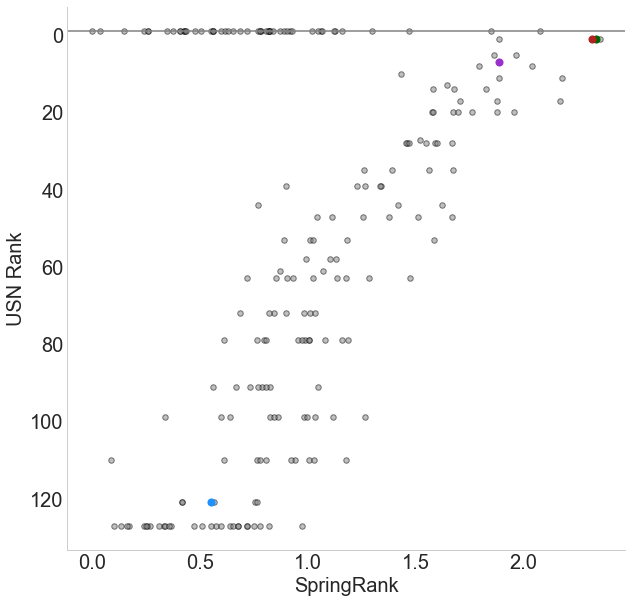

In [75]:
# USN Rank vs SpringRank
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)



# NEW VAR< SORT RANK
# Cast the values as integers, they may be strings now

plt.rcParams["axes.spines.right"] = False # Get rid of top and right axes/borders
plt.rcParams["axes.spines.top"] = False # Get rid of top and right axes/borders
plt.rcParams.update({'font.size': 20}) # Change font size

plt.scatter(ranks_sr[sorted_indices] - np.min(ranks_sr), int_CS_list[sorted_indices], s = 30, color = 'gray', alpha=0.5, edgecolor = 'black') # Markers are smaller & transparent
plt.gca().invert_yaxis()

plt.scatter(ranks_sr[1-1] - np.min(ranks_sr), int_CS_list[1-1], s = 50, color = 'darkgreen')
plt.scatter(ranks_sr[3-1] - np.min(ranks_sr), int_CS_list[3-1], s = 50, color = 'firebrick')
plt.scatter(ranks_sr[10-1] - np.min(ranks_sr), int_CS_list[10-1], s = 50, color = 'darkorchid')
plt.scatter(ranks_sr[173-1] - np.min(ranks_sr), int_CS_list[173-1], s = 50, color = 'dodgerblue')

plt.axhline(y = -1, color = 'gray', linestyle = '-')

plt.xlabel("SpringRank") # No need to tell them these are ranks
plt.ylabel("USN Rank")

plt.grid(False) # Remove grid

plt.show()

# Flip axis is not what we want; we're looking to manipulate such that we see a positive correlation
# Reversing vertices, last element becoems first element
# But last element of CS vertices corresponds to springrank; inverting


# MAKE A HORIZONTAL LINE AT -1, INDICATING THAT THESE ARE VALUES WITHOUT RANKS


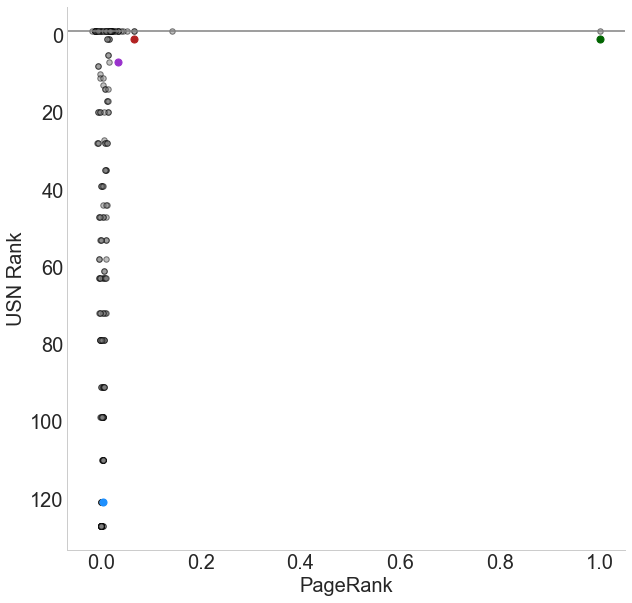

In [76]:
# USN Rank vs PageRank
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.rcParams["axes.spines.right"] = False # Get rid of top and right axes/borders
plt.rcParams["axes.spines.top"] = False # Get rid of top and right axes/borders
plt.rcParams.update({'font.size': 20}) # Change font size

plt.scatter(ranks_pr, int_CS_list[sorted_indices], s = 30, color = 'gray', alpha=0.5, edgecolor = 'black') # Markers are smaller & transparent

plt.gca().invert_yaxis()

plt.scatter(ranks_pr[1-1], int_CS_list[1-1], s = 50, color = 'darkgreen')
plt.scatter(ranks_pr[3-1], int_CS_list[3-1], s = 50, color = 'firebrick')
plt.scatter(ranks_pr[10-1], int_CS_list[10-1], s = 50, color = 'darkorchid')
plt.scatter(ranks_pr[173-1], int_CS_list[173-1], s = 50, color = 'dodgerblue')

# plt.gca().invert_yaxis()

plt.axhline(y = -1, color = 'gray', linestyle = '-')

plt.xlabel("PageRank") # No need to tell them these are ranks
plt.ylabel("USN Rank")

plt.grid(False) # Remove grid

plt.show()

# ::-1 tells me 1) where to start, 2) where to end, 3) how to move between numbers {2 would result in skipping each odd, -1 moves in other direction}

# Flip x axis

PageRank has high dropoff in ranks

Log plot not useful; this is like a point mass, reexpression will not help

USN does not rank uniquely; more than one university may have the same rank

Not all ranks are represented with this data set: formed by faculty hiring, then LEFT OUTER JOIN with USN2010; some USN missed

Not all universities in data had a rank, we assigned these a high rank

## Logit Plots
Not all universities were ranked by the logit model; the indices of those that were are save to the variable univ_indexes

In [77]:
CS_vertices['USN2010']#[univ_indexes]

0        1
1        1
2        1
3       11
4       17
      ... 
201    127
202     -1
203    127
204    127
205     -1
Name: USN2010, Length: 206, dtype: object

In [78]:
pd.DataFrame(CS_vertices['USN2010'])

,USN2010
0,1
1,1
2,1
3,11
4,17
...,...
201,127
202,-1
203,127
204,127


The periods as ranks are not a problem, they are more obviously unknown

Should find a way to order the USN rank though

In [79]:
len(ranks_logit)

180

In [80]:
univ_indexes

array([  23,   19,    8,    9,    3,   17,   26,   49,  197,   53,   58,
        101,  131,  227,   11,   63,  127,   65,  242,   74,  132,   92,
        296,  540,   61,  560,   22,  116,   15,   98,   55,   82,  504,
          2,   30,  110,    6,  229,   20,   28,  260,  176,  438,   44,
        620,    5, 1559,   35,  347,  182,   60,  146, 1362,  315,   25,
         76,  261,  700,   32,  729,  162,  789,  597,   36,  246,  228,
        119,  839,  522,   39,  394,  325, 1140,   40,  139,  507,  293,
       1825,   91,   33,  263,  754,  190,  458,  123,  873, 1616,  406,
        939,   29,  365,  103,  408,  326, 1102, 1061,   14,  215,  301,
        482,  739,  517,   43, 1266,   79,   73, 1357,  321,  390,  212,
        102,  237, 1178,  595, 3290,  279,  231, 3458, 1322,  909,  431,
        562,  924,  992,  697,  969,  922,  295, 3209, 3217, 1608, 1244,
        615,   12, 1064, 1013, 1360, 1887,  829, 2409,  876, 1160, 1381,
        577,  114,  585,  928,  179, 1986,  719, 14

In [81]:
univ

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118,
       119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133,
       134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 150, 151, 152, 153, 154, 155, 156, 160, 162, 163, 164, 166,
       167, 168, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 183,
       187, 188, 189, 190, 191, 192, 193, 194, 198, 204, 206], d

In [82]:
len(univ)

180

In [83]:
int_CS_list[univ-1]

0        1
1        1
2        1
3       11
4       17
      ... 
192    127
193    127
197    127
203    127
205     -1
Name: USN2010, Length: 180, dtype: int32

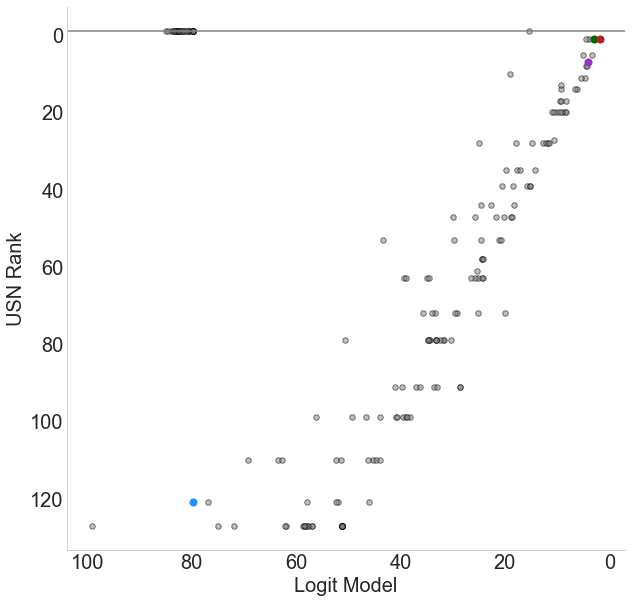

In [84]:
# USN Rank vs Logit
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.rcParams["axes.spines.right"] = False # Get rid of top and right axes/borders
plt.rcParams["axes.spines.top"] = False # Get rid of top and right axes/borders
plt.rcParams.update({'font.size': 20}) # Change font size

plt.scatter(ranks_logit, int_CS_list[univ-1], s = 30, color = 'gray', alpha=0.5, edgecolor = 'black') # Markers are smaller & transparent
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.scatter(ranks_logit[1-1], int_CS_list[1-1], s = 50, color = 'darkgreen')
plt.scatter(ranks_logit[3-1], int_CS_list[3-1], s = 50, color = 'firebrick')
plt.scatter(ranks_logit[10-1], int_CS_list[10-1], s = 50, color = 'darkorchid')
plt.scatter(ranks_logit[173-1], int_CS_list[173-1], s = 50, color = 'dodgerblue')

plt.axhline(y = -1, color = 'gray', linestyle = '-')

plt.xlabel("Logit Model") # No need to tell them these are ranks
plt.ylabel("USN Rank")

plt.grid(False) # Remove grid

plt.show()

# ::-1 tells me 1) where to start, 2) where to end, 3) how to move between numbers {2 would result in skipping each odd, -1 moves in other direction}

# Flip x axis